In [1]:
# 我们将使用CIFAR10数据集，它包含十个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。
# CIFAR-10 中的图像尺寸为3×32×32，也就是RGB的3层颜色通道，每层通道内的尺寸为32×32。

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms 

In [3]:
# torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量 Tensors。
# 方法一眼就能看懂，只是下载时区分训练集和测试集传bool显得有点迷
# 运行前 确认安装了 jupyter扩展 ipywidgets(https://ipywidgets.readthedocs.io/en/stable/user_install.html)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(3, 36, 138)


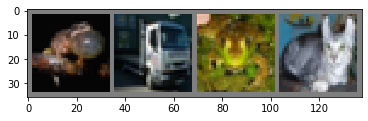

 frog truck  frog   cat


In [15]:
# 展示一下其中的一些图片
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # 看来要绘制图像 rgb必须去最后一个维度 (3,36,138)->(36,138,3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images, make_grid函数相当于是把几张图片拼接在一起
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [16]:
# 复制上一节的神经网络，将其改为3通道
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [17]:
import torch.optim as optim

# 使用交叉熵作为损失函数，随机梯度下降作为优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
# 训练，跑了2个epoch，很容易看懂，没什么值得说的
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.220
[1,  4000] loss: 1.190
[1,  6000] loss: 1.206
[1,  8000] loss: 1.196
[1, 10000] loss: 1.195
[1, 12000] loss: 1.150
[2,  2000] loss: 1.106
[2,  4000] loss: 1.086
[2,  6000] loss: 1.092
[2,  8000] loss: 1.099
[2, 10000] loss: 1.093
[2, 12000] loss: 1.097
Finished Training


(3, 36, 138)


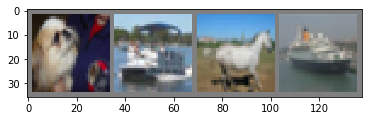

Ground Truth:    dog  ship horse  ship
Predicted   : dog ship truck ship


In [36]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images)
_,predicted = torch.max(outputs,1)
print('Predicted   :', ' '.join([classes[predicted[i]] for i in range(len(predicted))]))

In [37]:
# 结果看起来还不错，让我们看看网络在整个数据集上的表现。
correct = 0
total = 0
# 还记得这个不会计算梯度的代码块吗
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        # 统计样本总数和预测正确的样本数，方便计算准确率，
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [38]:
# 我得到的是59%，明显比随机预测好，至少说明了我们的训练是有效的。 如果加大网络模型和参数数量，提升准确率应该不难。
# 还可以分别统计每个种类识别的准确率
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 60 %
Accuracy of  bird : 41 %
Accuracy of   cat : 30 %
Accuracy of  deer : 43 %
Accuracy of   dog : 51 %
Accuracy of  frog : 72 %
Accuracy of horse : 66 %
Accuracy of  ship : 82 %
Accuracy of truck : 82 %


In [39]:
# 去GPU跑一波，先看看有没有可用的GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 如果有GPU，将输出 cuda:0
print(device)

cuda:0


In [40]:
# 接下来就当做有GPU了

In [ ]:
# 接着这些方法会递归地遍历所有模块，并将它们的参数和缓冲器转换为CUDA张量。
net = net.to(device)

In [71]:
# 损失函数也要转换
criterion = torch.nn.CrossEntropyLoss().to(device)
# 记住你也必须在每一个步骤向GPU发送输入和目标：

In [73]:
# 我在jupyter-lab中运行要报一个RuntimeError: expected device cpu but got device cuda:0 异常，而放到py文件中是可以正常运行的
# btw，windows在使用pytorch时会出现循环调用的错误，用if __name__ == '__main__':将主程序包起来可解决此问题
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: expected device cpu but got device cuda:0